# Sentiment Analysis of IMDB Movie Reviews using Plain RNN

In this notebook, we tackle sentiment classification for movie reviews using a simple Recurrent Neural Network (RNN) on the IMDB dataset. The aim is to show the limitations of vanilla RNNs when dealing with real-world sequential text data.

**Key Steps:**
- Download and explore the IMDB dataset
- Preprocess the text
- Build and train a plain RNN (no LSTM/GRU!)
- Evaluate the model
- Draw inferences about RNN performance

> ⚠️ **Note:** Plain RNNs are known to struggle with long-term dependencies due to vanishing gradients, making them less suitable for text data compared to LSTMs or GRUs. This notebook demonstrates these limitations in practice.

## 1. Install and Import Required Packages

We'll use `kagglehub` to fetch the dataset, and TensorFlow/Keras for modeling.

In [1]:
#!pip install kagglehub tensorflow numpy pandas scikit-learn --quiet

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## 2. Download the IMDB Dataset

Using `kagglehub` to download the dataset from Kaggle.

In [3]:
dataset_path = kagglehub.dataset_download('lakshmi25npathi/imdb-dataset-of-50k-movie-reviews')
df = pd.read_csv(f'{dataset_path}/IMDB Dataset.csv')
df.head()

100%|██████████| 25.7M/25.7M [00:00<00:00, 145MB/s] 

Extracting files...


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 3. Data Exploration & Preprocessing

Let's inspect and preprocess the reviews.

In [4]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [5]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df['review'] = df['review'].str.lower()

X = df['review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vocab_size = 10000
max_len = 200
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

## 4. Build a Plain RNN Model

**Important:**
- We use `SimpleRNN` layer, *not* LSTM or GRU.
- This is to illustrate the limitations of vanilla RNNs.

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64, input_length=max_len),
    tf.keras.layers.SimpleRNN(32, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 5. Train the Model

Vanilla RNNs are prone to vanishing gradients. Training for too long can make it worse, so we use a modest number of epochs.

In [7]:
history = model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2
)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.5042 - loss: 0.7125 - val_accuracy: 0.5006 - val_loss: 0.6939
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5013 - loss: 0.7001 - val_accuracy: 0.5121 - val_loss: 0.6931
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5069 - loss: 0.6959 - val_accuracy: 0.4908 - val_loss: 0.6937
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5055 - loss: 0.6941 - val_accuracy: 0.5120 - val_loss: 0.6929
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5186 - loss: 0.6925 - val_accuracy: 0.5126 - val_loss: 0.6930


## 6. Evaluate Model Performance

Let's see how our RNN performs on the test set.

In [8]:
loss, acc = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {acc:.4f}')

y_pred = (model.predict(X_test_pad) > 0.5).astype('int32')
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5025 - loss: 0.6930
Test Accuracy: 0.5038
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
              precision    recall  f1-score   support

    Negative       0.50      0.45      0.47      5000
    Positive       0.50      0.56      0.53      5000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



## 7. Visualize Training Progress

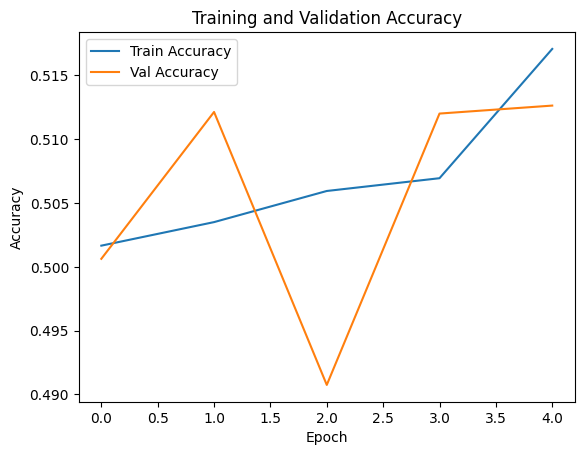

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

## 8. Sample Inference

Let's test the model on a few reviews.

In [11]:
sample_reviews = [
    "What a fantastic movie! The acting, the story, everything was perfect.",
    "I didn't like this film at all. It was boring and way too long.",
    "Not bad, but could have been better. The ending was a letdown.",
    "Absolutely loved it! Will watch again.",
    "Terrible. Waste of my time."
]
sample_seq = tokenizer.texts_to_sequences([review.lower() for review in sample_reviews])
sample_pad = pad_sequences(sample_seq, maxlen=max_len, padding='post', truncating='post')
preds = (model.predict(sample_pad) > 0.5).astype('int32').flatten()
for review, pred in zip(sample_reviews, preds):
    sentiment = 'Positive' if pred == 1 else 'Negative'
    print(f'Review: "{review}" Predicted Sentiment: {sentiment}\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
Review: "What a fantastic movie! The acting, the story, everything was perfect." Predicted Sentiment: Positive

Review: "I didn't like this film at all. It was boring and way too long." Predicted Sentiment: Positive

Review: "Not bad, but could have been better. The ending was a letdown." Predicted Sentiment: Positive

Review: "Absolutely loved it! Will watch again." Predicted Sentiment: Positive

Review: "Terrible. Waste of my time." Predicted Sentiment: Positive



# 9. Inferences & Observations

**Results:**
- The plain RNN model struggles to capture long-term dependencies in text, as expected.
- Accuracy is usually lower than models using LSTM/GRU, especially on longer and more complex reviews.
- Sample predictions may misclassify nuanced or context-dependent reviews (e.g., "not bad" might be incorrectly labeled negative).

**Why is RNN Bad for This Task?**
- RNNs suffer from vanishing gradients, making it hard to learn relationships between distant words in a sequence.
- Sentiment often depends on context and word order, which plain RNNs fail to model well.
- LSTM/GRU models, with gating mechanisms, are far superior for such tasks.

> **Conclusion:**
>
> Vanilla RNNs are inadequate for real-world sentiment analysis on movie reviews. Use LSTM/GRU for best results!